In [1]:
import json, sys, os, math
sys.path.append(os.path.abspath("backend/app"))
from Functions import functions
import pandas as pd, numpy as np
import xarray as xr, matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [44]:
hyd_map_path = r'backend\Delft_Projects\demo\output\HYD\FlowFM_map.zarr'
# hyd_his_path = r'backend\Delft_Projects\demo\output\HYD\FlowFM_his.zarr'
# wq_his_path = r'backend\Delft_Projects\demo\output\WAQ\Cadmium_his.zarr'
wq_map_path = r'backend\Delft_Projects\demo\output\WAQ\Cadmium_map.zarr'
# waq_his = xr.open_zarr(wq_his_path)
waq_map = xr.open_zarr(wq_map_path)
# hyd_his = xr.open_zarr(hyd_his_path)
hyd_map = xr.open_zarr(hyd_map_path)
# # Save to zarr
# hyd_map.to_zarr(r'backend\Delft_Projects\team\output\HYD\FlowFM_map.zarr', mode='w', consolidated=False)

In [137]:
query, time_column, data_, key = 'temp_multi_dynamic', 'time', hyd_map, 'hyd'
ids = [125, 128, 774, 775, 1441, 1445, 2124, 2125, 2795, 2798, 3247, 2635, 2632, 1975, 1974, 1976, 1334, 1331, 687]
name = functions.variablesNames.get(query, query)
time_stamps = pd.to_datetime(data_[time_column]).strftime('%Y-%m-%d %H:%M:%S').tolist()
temp_grid = functions.unstructuredGridCreator(hyd_map).copy()
temp_grid['depth'] = functions.interpolation_Z(temp_grid,
    data_['mesh2d_node_x'].values, data_['mesh2d_node_y'].values, data_['mesh2d_node_z'].values
)
layer_reverse = functions.layerCounter(data_)
n_layers_values = [float(v.split(' ')[1]) for k, v in layer_reverse.items() if int(k) >= 0]
max_layer, n_decimal = max(n_layers_values, key=abs), 4
n_rows, n_cols = len(ids), math.ceil(max_layer/10)*10 if max_layer > 0 else math.floor(max_layer/10)*10
status, message, values, vmin, vmax, max_row = 'ok', '', {}, 1e20, -1e-20, 0
filtered = temp_grid.loc[ids].copy()  # Filter by ids

In [ ]:
temp_val, idx = [], -1
for i in range(len(n_layers_values)):
    layer_idx = len(layer_reverse) - i - 2
    if key == 'hyd': layer_data = data_[name].values[idx, :, layer_idx]
    else: layer_data = data_[name].values[idx, layer_idx, :]
    temp_df = pd.DataFrame(functions.numberFormatter(layer_data, n_decimal)).loc[ids]
    temp_val.append(temp_df.values.flatten().tolist())
temp_val, depth_indices = np.array(temp_val, dtype=float), [int(abs(round(d))) for d in n_layers_values]
arr = np.full((abs(n_cols), n_rows), None, dtype=object)
# Fill array with interpolated profile
for i, depth in enumerate(filtered['depth'].values):
    depth = int(abs(round(depth)))
    arr[depth-1, i] = functions.interpolate_Profile(temp_val, depth_indices, depth, i)
# Convert None values to nan
arr = np.array([[np.nan if v is None else v for v in row] for row in arr], dtype=float)
# Fill other missing values at specific depths
for i in range(arr.shape[1]):
    series, mask_arr = temp_val[:, i], ~np.isnan(arr[:, i])
    valid_positions = np.array(depth_indices)[~np.isnan(series)]
    valid_positions_arr = np.arange(arr.shape[0])[mask_arr]
    if len(valid_positions_arr) == 0: continue
    mask_result = valid_positions[valid_positions<=valid_positions_arr[-1]]
    if len(mask_result) == 0: continue
    for j, position in enumerate(mask_result):
        if np.isnan(arr[int(position)-1, i]): arr[int(position)-1, i] = series[j]

In [157]:
pd.DataFrame(arr).head(30)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8498
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.2375,9.198,9.1434,9.1114,9.0021,8.9633,8.8381,8.8581,8.85080,8.82110,8.8333,8.80800,8.7619,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
5,NaN,9.198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7951,NaN,NaN
6,9.2375,NaN,9.1434,9.1114,NaN,8.9633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7921,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.6700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


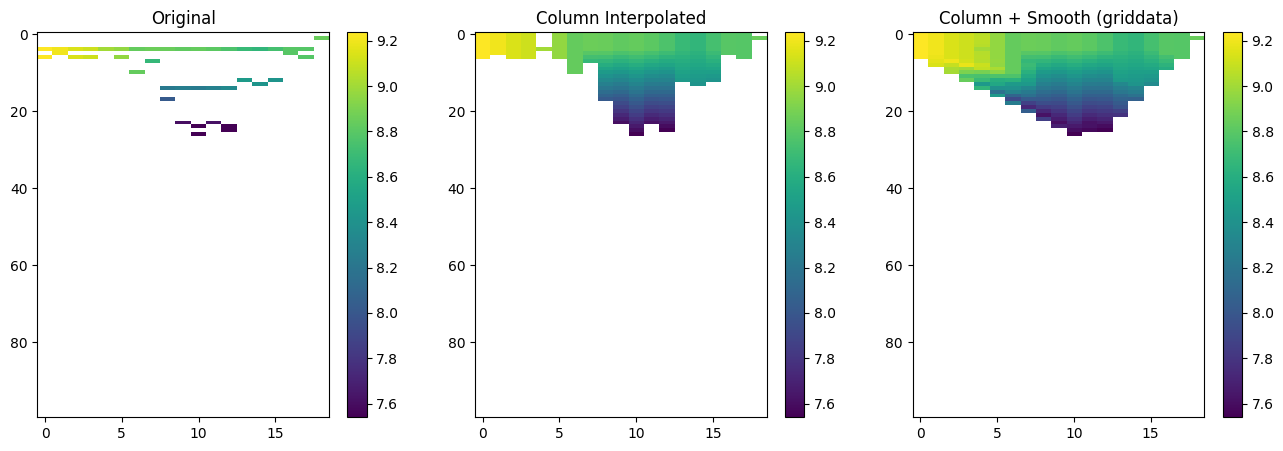

In [158]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# ==== NHẬP MẢNG CỦA BẠN Ở ĐÂY ====



def vertical_fill(arr):
    arr = arr.copy().astype(float)
    rows, cols = arr.shape

    for col in range(cols):
        col_data = arr[:, col]
        valid = ~np.isnan(col_data)

        if valid.sum() >= 2:
            x = np.where(valid)[0]
            y = col_data[valid]
            first, last = x[0], x[-1]

            interp_rows = np.arange(0, last+1)
            interp_vals = np.interp(interp_rows, [first, last], [col_data[first], col_data[last]])
            arr[0:last+1, col] = interp_vals

    return arr


def full_fill(arr):
    arr = vertical_fill(arr)

    x, y = np.indices(arr.shape)
    x_known, y_known = x[~np.isnan(arr)], y[~np.isnan(arr)]
    values_known = arr[~np.isnan(arr)]

    xi, yi = np.indices(arr.shape)

    filled = griddata(
        points=(x_known, y_known),
        values=values_known,
        xi=(xi, yi),
        method='cubic',
        fill_value=np.nan  # không phá giá trị gốc
    )

    return filled


# Tính các phiên bản
arr_raw = arr
arr_vertical = vertical_fill(arr)
arr_full = full_fill(arr)

# ==== VẼ BIỂU ĐỒ ====
fig, axs = plt.subplots(1, 3, figsize=(16,5))

for ax, data, title in zip(
    axs,
    [arr_raw, arr_vertical, arr_full],
    ["Original", "Column Interpolated", "Column + Smooth (griddata)"]
):
    im = ax.imshow(data, aspect='auto')  # không set màu → mặc định
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.show()


In [160]:
pd.DataFrame(arr).head(30)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8498
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.2375,9.198,9.1434,9.1114,9.0021,8.9633,8.8381,8.8581,8.85080,8.82110,8.8333,8.80800,8.7619,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
5,NaN,9.198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7951,NaN,NaN
6,9.2375,NaN,9.1434,9.1114,NaN,8.9633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7921,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.6700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
pd.DataFrame(arr_vertical).head(30)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,9.2375,9.198,9.1434,9.1114,NaN,8.9633,8.8381,8.8581,8.850800,8.821100,8.833300,8.808000,8.761900,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
1,9.2375,9.198,9.1434,9.1114,NaN,8.9633,8.8381,8.8581,8.850800,8.821100,8.833300,8.808000,8.761900,8.68120,8.65470,8.73400,8.7951,8.7921,8.8498
2,9.2375,9.198,9.1434,9.1114,NaN,8.9633,8.8381,8.8581,8.850800,8.821100,8.833300,8.808000,8.761900,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
3,9.2375,9.198,9.1434,9.1114,NaN,8.9633,8.8381,8.8581,8.850800,8.821100,8.833300,8.808000,8.761900,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
4,9.2375,9.198,9.1434,9.1114,9.0021,8.9633,8.8381,8.8581,8.850800,8.821100,8.833300,8.808000,8.761900,8.68120,8.65470,8.73400,8.7951,8.7921,NaN
5,9.2375,9.198,9.1434,9.1114,NaN,8.9633,8.8381,8.7954,8.786956,8.757334,8.774791,8.745439,8.703695,8.65409,8.62809,8.69477,8.7951,8.7921,NaN
6,9.2375,NaN,9.1434,9.1114,NaN,8.9633,8.8381,8.7327,8.723112,8.693568,8.716282,8.682878,8.645490,8.62698,8.60148,8.65554,NaN,8.7921,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,8.8381,8.6700,8.659268,8.629803,8.657773,8.620317,8.587286,8.59987,8.57487,8.61631,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,8.8381,NaN,8.595425,8.566037,8.599264,8.557756,8.529081,8.57276,8.54826,8.57708,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,8.8381,NaN,8.531581,8.502271,8.540755,8.495195,8.470876,8.54565,8.52165,8.53785,NaN,NaN,NaN


In [74]:
pd.DataFrame(temp_val)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.45,3.45,3.45,3.45,3.45,3.45,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,NaN,NaN,NaN
9,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45,3.45


In [37]:
ids = [125, 128, 774, 775, 1441, 1445, 2124, 2125, 2795, 2798, 3247, 2635, 2632, 1975, 1974, 1976, 1334, 1331, 687]
data_, time_column, query = hyd_map, 'time', 'mesh2d_tem1'
name = functions.variablesNames[query] if query in functions.variablesNames.keys() else query
time_stamps = [pd.to_datetime(id).strftime('%Y-%m-%d %H:%M:%S') for id in data_[time_column].values]
temp_grid = functions.unstructuredGridCreator(hyd_map).copy()
temp_grid['depth'] = functions.interpolation_Z(temp_grid, hyd_map['mesh2d_node_x'].values, 
                        hyd_map['mesh2d_node_y'].values, hyd_map['mesh2d_node_z'].values)
# temp_grid.to_file('temp_grid.geojson', driver='GeoJSON')
# Reverse layers
n_layers = hyd_map['mesh2d_layer_z'].values[::-1].tolist()
number = max(n_layers, key=abs)
values, n_rows, n_cols = {}, len(ids), math.ceil(number/10)*10 if number > 0 else math.floor(number/10)*10
vmin, vmax, max_row = 1e20, -1e-20, 0
for i in range(len(time_stamps)):
    temp, temp_val = temp_grid.drop(columns=['geometry']).copy(), []
    filtered = temp[temp.index.isin(ids)]  # Filter by ids
    filtered = filtered.loc[ids] # Ensure the order of ids
    for j in range(len(n_layers)):
        df_temp = pd.DataFrame({'value': functions.numberFormatter(data_[name].values[i, :, len(n_layers) - (j + 1)], 8)})
        # print(temp, df_temp)
        filtered_join = filtered.join(df_temp)
        temp_val.append(filtered_join['value'].values.flatten())
    arr = np.full((abs(n_cols), n_rows), None, dtype=object)
    depth_indices = [int(abs(round(d))) for d in n_layers]
    temp_val, init_depth = np.array(temp_val), filtered['depth'].values
    # Fill bottom values into array with interpolated depths
    for idx, depth in enumerate(init_depth):
        depth = int(abs(round(depth)))
        arr[depth-1, idx] = functions.interpolate_Profile(temp_val, depth_indices, depth, idx)
    # Convert None values to nan
    arr = np.array([[np.nan if v is None else v for v in row] for row in arr], dtype=float)
    # Fill other missing values at specific depths
    for k in range(arr.shape[1]):
        series, idx_arr = temp_val[:, k], arr[:, k]
        mask, mask_arr = ~np.isnan(series), ~np.isnan(idx_arr)
        valid_positions = np.array(depth_indices)[mask]
        valid_positions_arr = np.arange(arr.shape[0])[mask_arr]
        if len(valid_positions_arr) == 0: continue
        mask_result = valid_positions[valid_positions<=valid_positions_arr[-1]]
        if len(mask_result) == 0: continue
        for idx, position in enumerate(mask_result):
            if np.isnan(arr[int(position)-1, k]): arr[int(position)-1, k] = series[idx]
    # Fill missing top values
    for k in range(arr.shape[1]):
        mask = ~np.isnan(arr[:, k])
        valid_positions = np.where(mask)[0]
        if np.isnan(arr[0, k]) and len(valid_positions) > 0:
            arr[0, k] = arr[valid_positions[0], k]
    # Get max index with non-nan value
    max_indices = []
    for k in range(arr.shape[1]):
        valid_positions = np.where(~np.isnan(arr[:, k]))[0]
        temp = int(valid_positions[-1]) if len(valid_positions) > 0 else 0
        max_indices.append(temp)
    # Create grid
    x, y = np.indices(arr.shape)
    # Get real value points
    x_known, y_known = x[~np.isnan(arr)], y[~np.isnan(arr)]
    values_known = arr[~np.isnan(arr)]
    # Create grid
    xi, yi = np.indices(arr.shape)
    # Create linear interpolation
    filled = griddata(points=(x_known, y_known), values=values_known, xi=(xi, yi), method='cubic')
    # Adjust filled values based on max indices
    for k, value in enumerate(max_indices):
        filled[value+1:, k] = np.nan
    # Define the largest row that contains at least one non-nan value
    valid_rows = np.where(~np.isnan(filled).all(axis=1))[0]
    if len(valid_rows) > 0:
        max_valid_row = valid_rows.max()
        if max_valid_row > max_row: max_row = max_valid_row
    # Set vmin and vmax
    vmin = float(np.nanmin(filled)) if float(np.nanmin(filled)) < vmin else vmin
    vmax = float(np.nanmax(filled)) if float(np.nanmax(filled)) > vmax else vmax
    values[time_stamps[i]] = filled.tolist()
# Trim values to max_row
for key in values.keys():
    temp = np.array(values[key])
    values[key] = temp[:max_row+2, :].tolist()
# Restructure data to send to frontend
heights = np.arange(0, max_row+2) if n_cols > 0 else np.arange(0, -(max_row+2), -1)
data = { "timestamps": time_stamps, "ids": ids, "depths": heights.tolist(), "values": values, "minmax": [vmin, vmax] }
data = functions.clean_nans(data)


KeyboardInterrupt: 

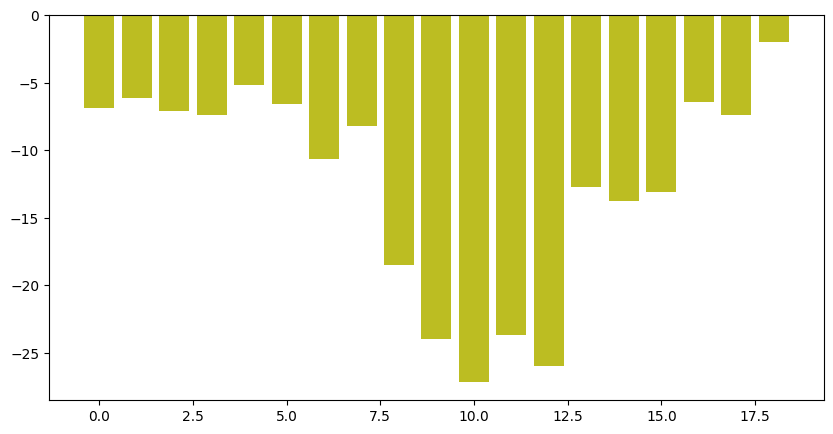

In [175]:
# Plot bar plot
fig, ax = plt.subplots(figsize=(10, 5))
for i, id_ in enumerate(ids):
    ax.bar(filtered['x'], filtered['depth'].values, width=0.8, align='center')

In [23]:
n_layers, depth_indices, init_depth, len(init_depth)

([-4.986608286368211,
  -14.959824859104634,
  -24.933041431841055,
  -34.90625800457748,
  -44.8794745773139,
  -54.85269115005032,
  -64.82590772278674,
  -74.79912429552316,
  -84.77234086825958,
  -94.745557440996],
 [5, 15, 25, 35, 45, 55, 65, 75, 85, 95],
 array([ -6.89,  -6.15,  -7.08,  -7.35,  -5.19,  -6.59, -10.63,  -8.22,
        -18.46, -23.96, -27.15, -23.69, -25.96, -12.72, -13.77, -13.1 ,
         -6.4 ,  -7.37,  -1.99]),
 19)

In [164]:
pd.DataFrame(temp_val)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,3.918003
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.967281,3.950280,3.934863,3.927854,3.915845,3.911372,3.902340,3.897556,3.897424,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.935243,3.931358,3.927854,3.915846,3.911373,3.902341,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
pd.DataFrame(arr).head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,3.918003
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.918003
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,NaN
5,NaN,4.087177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.886576,NaN,NaN
6,4.083532,NaN,4.066326,4.055529,NaN,4.015417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.894525,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.968009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
pd.DataFrame(filled).head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,3.918003
1,4.082704,4.085468,4.065718,4.055378,4.028959,4.014911,3.974465,3.966696,3.950528,3.934564,3.927256,3.915962,3.911164,3.902468,3.899298,3.898555,3.890332,3.897698,3.918003
2,4.082207,4.085431,4.064614,4.055288,4.027654,4.014607,3.973022,3.966511,3.950691,3.934385,3.927085,3.916032,3.911254,3.902546,3.900488,3.899235,3.890338,3.896808,NaN
3,4.082373,4.086267,4.064366,4.055318,4.027079,4.014708,3.972451,3.967231,3.950648,3.934445,3.927298,3.916009,3.911402,3.902520,3.900211,3.899008,3.888463,3.895150,NaN
4,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,NaN
5,4.085815,4.087177,4.068702,4.055443,NaN,4.015089,3.980803,3.968846,3.949569,3.938982,3.925254,3.915590,3.910873,3.902035,3.894509,3.889362,3.886576,3.893892,NaN
6,4.083532,NaN,4.066326,4.055529,NaN,4.015417,3.988139,3.968572,3.952015,3.936918,3.924912,3.915334,3.909810,3.901708,3.894082,3.888480,NaN,3.894525,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,3.989863,3.968009,3.950962,3.936513,3.924596,3.915089,3.908248,3.901413,3.893793,3.888101,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.986042,NaN,3.950707,3.936219,3.924306,3.914867,3.907184,3.901206,3.893648,3.888987,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,3.980253,NaN,3.949772,3.936402,3.924302,3.914690,3.907206,3.901140,3.893940,3.890919,NaN,NaN,NaN


In [94]:
init_depth

array([ -1.84,  -1.67,  -4.54,  -4.54,  -4.06, -17.81, -11.6 ,  -7.58,
        -6.59, -25.47, -22.31, -12.58, -10.76, -35.55, -32.44, -21.43,
       -18.42, -46.4 , -43.64, -27.8 , -25.62, -55.67, -53.86, -29.26,
       -30.96, -59.47, -59.25, -30.09, -34.13, -60.  , -60.  , -33.49,
       -33.68, -59.55, -59.94, -37.73, -54.79, -56.83, -45.85, -38.14,
       -45.72, -48.  , -45.59])

In [183]:
# data = pd.read_csv('ok.csv', index_col=0)
data = pd.DataFrame(values[time_stamps[-1]])
data.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,3.918003
1,4.082704,4.085468,4.065718,4.055378,4.028959,4.014911,3.974465,3.966696,3.950528,3.934564,3.927256,3.915962,3.911164,3.902468,3.899298,3.898555,3.890332,3.897698,3.918003
2,4.082207,4.085431,4.064614,4.055288,4.027654,4.014607,3.973022,3.966511,3.950691,3.934385,3.927085,3.916032,3.911254,3.902546,3.900488,3.899235,3.890338,3.896808,NaN
3,4.082373,4.086267,4.064366,4.055318,4.027079,4.014708,3.972451,3.967231,3.950648,3.934445,3.927298,3.916009,3.911402,3.902520,3.900211,3.899008,3.888463,3.895150,NaN
4,4.083532,4.087177,4.066326,4.055529,4.029113,4.015417,3.974764,3.968320,3.950279,3.934862,3.927853,3.915845,3.911371,3.902339,3.897555,3.897423,3.886576,3.894525,NaN
5,4.085815,4.087177,4.068702,4.055443,NaN,4.015089,3.980803,3.968846,3.949569,3.938982,3.925254,3.915590,3.910873,3.902035,3.894509,3.889362,3.886576,3.893892,NaN
6,4.083532,NaN,4.066326,4.055529,NaN,4.015417,3.988139,3.968572,3.952015,3.936918,3.924912,3.915334,3.909810,3.901708,3.894082,3.888480,NaN,3.894525,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,3.989863,3.968009,3.950962,3.936513,3.924596,3.915089,3.908248,3.901413,3.893793,3.888101,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.986042,NaN,3.950707,3.936219,3.924306,3.914867,3.907184,3.901206,3.893648,3.888987,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,3.980253,NaN,3.949772,3.936402,3.924302,3.914690,3.907206,3.901140,3.893940,3.890919,NaN,NaN,NaN


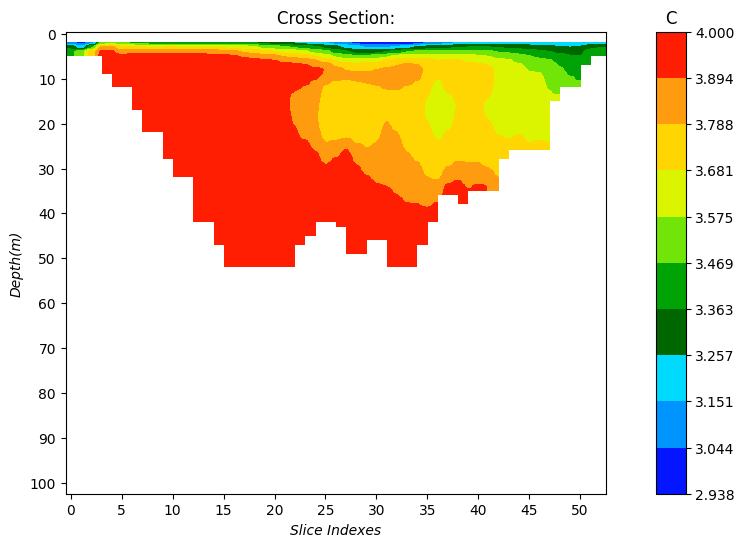

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8, 6))
temp_cmap = ["#0416FF", "#0094FF", "#00DAFF", "#006600", "#00A305", "#71E507", "#DBF400", "#FFD602",
                "#FF9B0F", "#FF1E01"]
cmap = colors.ListedColormap(temp_cmap)
# Get min and max values of the data
min_value, max_value = data.min().min(), data.max().max()
if min_value < max_value: boundaries = np.linspace(min_value, max_value, cmap.N + 1).tolist()
else: boundaries = np.linspace(0, max_value, cmap.N + 1).tolist()
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
img = ax.imshow(data, interpolation='kaiser', cmap=colors.ListedColormap(temp_cmap), norm=norm, aspect='auto')
cax = cax = make_axes_locatable(ax).append_axes("right", size=0.3, pad=0.5)
colorbar = fig.colorbar(img, cax=cax, ticks=boundaries)
colorbar.ax.set_title('C')
ax.set_title("Cross Section:")
ax.tick_params(axis='x', rotation=0, labelsize=10)
ax.tick_params(axis='y', rotation=0, labelsize=10)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_ylabel("Depth(m)", fontsize=10, style='italic')
ax.set_xlabel("Slice Indexes", fontsize=10, style='italic')
ax.set_xticks(np.arange(0, len(data.columns) + 1, 5))
ax.set_yticks(np.arange(0, len(data), 10))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_cross_section(df_grid, variable="Variable", unit="", color_list=None):
    """
    Vẽ cross-section heatmap từ DataFrame df_grid
    
    Args:
        df_grid (pd.DataFrame): DataFrame với index = depth, columns = slice index
        variable (str): Tên biến để hiển thị
        unit (str): Đơn vị của biến
        color_list (list): Danh sách màu cho colormap
    """
    
    if color_list is None:
        # Colormap mặc định (10 màu gradient)
        color_list = ["#0416FF", "#0094FF", "#00DAFF", "#006600", "#00A305", 
                      "#71E507", "#DBF400", "#FFD602", "#FF9B0F", "#FF1E01"]
    
    # Chuyển sang numpy array
    data = df_grid.values.astype(float)
    
    # Xác định min/max
    min_value, max_value = np.nanmin(data), np.nanmax(data)
    
    # Colormap
    cmap = colors.ListedColormap(color_list)
    if min_value < max_value:
        boundaries = np.linspace(min_value, max_value, cmap.N + 1)
    else:
        boundaries = np.linspace(0, max_value, cmap.N + 1)
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
    # Vẽ
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(data, interpolation='kaiser', cmap=cmap, norm=norm, aspect='auto')
    
    # Grid và labels
    ax.grid(False)
    ax.set_title(f"Cross Section: {variable}")
    ax.set_xlabel("Slice Indexes", fontsize=10, style='italic')
    ax.set_ylabel("Depth (m)", fontsize=10, style='italic')
    
    # Ticks
    ax.set_xticks(np.arange(0, df_grid.shape[1], max(1, df_grid.shape[1]//10)))
    ax.set_yticks(np.arange(0, df_grid.shape[0], max(1, df_grid.shape[0]//10)))
    
    # Colorbar
    cbar = fig.colorbar(img, ax=ax, ticks=boundaries)
    cbar.ax.set_title(unit)
    
    plt.show()

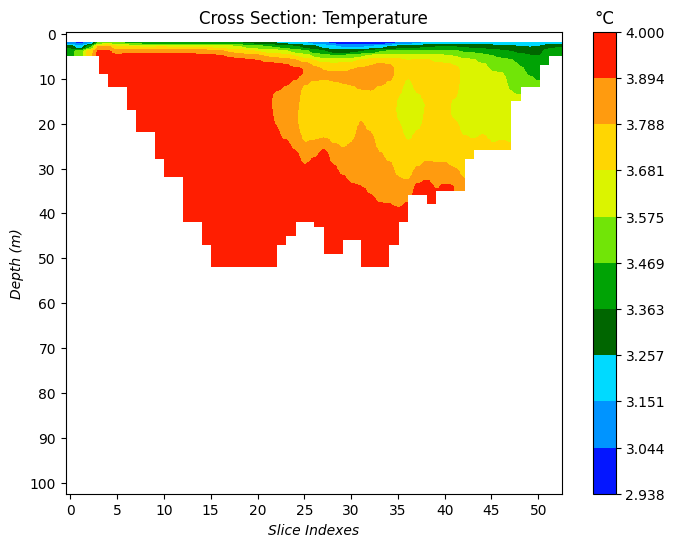

In [27]:
plot_cross_section(data, variable="Temperature", unit="°C")

In [23]:
# Get units
for key, var in waq_his.variables.items():
    # units = var.attrs.get('long_name', 'units')
    # print(f"{var}: {units}")
    print(key, var)

nTimesDlwqBnd <xarray.Variable (nTimesDlwq: 6, Two: 2)> Size: 96B
[12 values with dtype=datetime64[ns]]
ASWTOT <xarray.Variable (nTimesDlwq: 6, nStations: 3)> Size: 72B
[18 values with dtype=float32]
Attributes:
    delwaq_name:  ASWTOT
    long_name:    ASWTOT
    unit:         
    units:        
CUWTOT <xarray.Variable (nTimesDlwq: 6, nStations: 3)> Size: 72B
[18 values with dtype=float32]
Attributes:
    delwaq_name:  CUWTOT
    long_name:    CUWTOT
    unit:         
    units:        
NIWTOT <xarray.Variable (nTimesDlwq: 6, nStations: 3)> Size: 72B
[18 values with dtype=float32]
Attributes:
    delwaq_name:  NIWTOT
    long_name:    NIWTOT
    unit:         
    units:        
PBWTOT <xarray.Variable (nTimesDlwq: 6, nStations: 3)> Size: 72B
[18 values with dtype=float32]
Attributes:
    delwaq_name:  PBWTOT
    long_name:    PBWTOT
    unit:         
    units:        
POCW <xarray.Variable (nTimesDlwq: 6, nStations: 3)> Size: 72B
[18 values with dtype=float32]
Attributes:
    de

In [15]:
list(waq_map.variables.keys())

['mesh2d',
 'mesh2d_node_x',
 'mesh2d_node_y',
 'mesh2d_edge_x',
 'mesh2d_edge_y',
 'mesh2d_face_x_bnd',
 'mesh2d_face_y_bnd',
 'mesh2d_edge_nodes',
 'mesh2d_edge_faces',
 'mesh2d_face_nodes',
 'mesh2d_layer_dlwq',
 'nTimesDlwqBnd',
 'mesh2d_NH4',
 'mesh2d_2d_NH4',
 'mesh2d_CBOD5',
 'mesh2d_2d_CBOD5',
 'mesh2d_OXY',
 'mesh2d_2d_OXY',
 'mesh2d_SOD',
 'mesh2d_2d_SOD',
 'mesh2d_DO',
 'mesh2d_2d_DO',
 'mesh2d_volume',
 'mesh2d_2d_volume',
 'mesh2d_face_x',
 'mesh2d_face_y',
 'nTimesDlwq']

## Preprocess data

In [4]:
velocity_layers = functions.velocityChecker(data_map)
# Write velocity layer file
with open(f'{temp_folder}/velocity_layers.json', 'w') as f:
    json.dump(velocity_layers, f)

In [ ]:
# Get summary of the project
data = functions.getSummary(dia_file, data_his, wq_map)

In [3]:
# Generate config file
configuration, NCfiles = {}, [data_his, data_map, wq_his, wq_map]
for file in NCfiles:
    configuration.update(functions.getVariablesNames(file))
# Write config file
with open(f'{temp_folder}/configuration.json', 'w') as f:
    json.dump(configuration, f)

Checking General Hydrological File ...
Checking General Map File ...
Checking Water Quality History File ...
Checking Water Quality Map File ...


## Process his data

### Time-series data

In [ ]:
# # =============================== POINTS ===============================
# # Location of stations
# stations = functions.stationCreator(data_his)
# stations.to_file(f'{geojson_folder}/stations.geojson', driver='GeoJSON')

# columns = [name.decode('utf-8').strip() for name in data_his['station_name'].values]
# values = ['waterlevel', 'waterdepth', 'total_heat_flux', 'wind_speed', 'air_temperature', 'relative_humidity',
#           'evaporative_heat_flux', 'free_convection_evaporative_heat_flux', 'sensible_heat_flux',
#           'free_convection_sensible_heat_flux', 'long_wave_back_radiation', 'precipitation_rate', 'solar_influx', 'cloudiness']
# for i in values:
#     df = functions.timeseriesCreator(data_his, i, columns)
#     df.to_json(f'{data_folder}/{i}.json', orient='split', date_format='iso', indent=3)

# # =============================== CROSS SECTION ===============================
# section_names = [name.decode('utf-8').strip() for name in data_his['cross_section_name'].values]






# # =============================== WATER BALANCE ===============================
# column_name = ['Water Balance']
# values = ['water_balance_total_volume', 'water_balance_storage', 'water_balance_boundaries_in',
#           'water_balance_boundaries_out', 'water_balance_boundaries_total', 'water_balance_precipitation_total',
#           'water_balance_evaporation', 'water_balance_source_sink', 'water_balance_groundwater_in',
#           'water_balance_groundwater_out', 'water_balance_groundwater_total', 'water_balance_precipitation_on_ground',
#           'water_balance_volume_error']
# for i in values:
#     df = functions.timeseriesCreator(data_his, i, column_name)
#     df.to_json(f'{data_folder}/{i}.json', orient='split', date_format='iso', indent=3)


# # Bed shear stress at stations
# df_x = delft3d.tausx.rename(columns={key: f'{key}_x' for key in delft3d.tausx.columns})
# df_y = delft3d.tausy.rename(columns={key: f'{key}_y' for key in delft3d.tausy.columns})
# df_bss = pd.concat([df_x, df_y], axis=1)
# df_bss.reset_index().to_json(f'{data_folder}/bed_shear_stress_timeseries.json', orient='split', date_format='iso', indent=3)

## Process map data

In [6]:
# # Create unstructured grid
# grid = functions.unstructuredGridCreator(data_map)

### Prepare static map

In [7]:
# # Depth at every mesh (for unstructured grid) that is interpolated from depth at nodes
# temp = grid.copy()
# temp['value'] = functions.interpolation_Z(temp, data_map['mesh2d_node_x].values, data_map['mesh2d_node_y'].values, data_map['mesh2d_node_z'].values)
# temp['value'] = temp['value'].apply(lambda x: round(x, 2))
# temp.to_file(f'{geojson_folder}/depth_static.geojson', driver='GeoJSON')

### Prepare dynamic map

In [8]:
# values = ['water_surface_dynamic', 'water_depth_dynamic',
#           'temperature_multilayers', 'salinity_multilayers', 'contaminant_multilayers']
# for i in values:
#     data = functions.assignValuesToMeshes(grid, data_map, i)
#     data.to_file(f'{geojson_folder}/{i}.geojson', driver='GeoJSON')

## OLD VERSION

### 2. Prepare template data for the option *'Cross-sections'* on menu

In [5]:
# # Location of cross-sections
# delft3d.cross_section.to_file(f'{geojson_folder}/crosssections.geojson', driver='GeoJSON')
# # Discharge at cross-sections
# delft3d.cross_section_discharges.reset_index().to_json(f'{timeseries_folder}/crossdischarge_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cumulative discharge at cross-sections
# delft3d.cross_section_cumulative_discharge.reset_index().to_json(f'{timeseries_folder}/crosscumulative_discharge_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section area
# delft3d.cross_section_area.reset_index().to_json(f'{timeseries_folder}/crossarea_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section velocity
# delft3d.cross_section_velocity.reset_index().to_json(f'{timeseries_folder}/crossvelocity_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section salinity
# delft3d.cross_section_salinity.reset_index().to_json(f'{timeseries_folder}/crosssalinity_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative salinity
# delft3d.cross_section_cumulative_salinity.reset_index().to_json(f'{timeseries_folder}/crosscumulative_salinity_timeseries.json', orient='records', date_format='iso', indent=3)
# Cross-section temperature
# delft3d.cross_section_temperature.reset_index().to_json(f'{timeseries_folder}/crosstemperature_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative temperature
# delft3d.cross_section_cumulative_temperature.reset_index().to_json(f'{timeseries_folder}/crosscumulative_temperature_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section contaminant
# delft3d.cross_section_contaminant.reset_index().to_json(f'{timeseries_folder}/crosscontaminant_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative contaminant
# delft3d.cross_section_cumulative_contaminant.reset_index().to_json(f'{timeseries_folder}/crosscumulative_contaminant_timeseries.json', orient='records', date_format='iso', indent=3)

### 3. Prepare template data for the option *'Water Balance'* on menu

In [ ]:
# column_name = 'Water Balance'
# data = delft3d.waterbalance_volumeerror.rename(columns={0: f'{column_name}'})
# data.reset_index().to_json(f'{temp_folder}/data/waterbalance_volumeerror.json', orient='split', date_format='iso', indent=3)

In [ ]:
# column_name = 'Water Balance'
# # Water balance total volume
# delft3d.waterbalance_totalvolume.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_totalvolume_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance storage
# delft3d.waterbalance_storage.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_storage_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary inflow
# delft3d.waterbalance_boundariesin.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundariesin_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary outflow
# delft3d.waterbalance_boundariesout.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundariesout_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary total
# delft3d.waterbalance_boundariestotal.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundaries_total_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance precipitation
# delft3d.waterbalance_precipitation.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_precipitation_total_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance evaporation
# delft3d.waterbalance_evaporation.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_evaporation_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance source sink
# delft3d.waterbalance_sourcesink.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_sourcesink_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater in
# delft3d.waterbalance_groundwaterin.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwaterin_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater out
# delft3d.waterbalance_groundwaterout.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwaterout_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater total
# delft3d.waterbalance_groundwatertotal.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwatertotal_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance precipitation on ground
# delft3d.waterbalance_precipitationonground.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_precipitationonground_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance total volume error
# delft3d.waterbalance_volumeerror.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_volumeerror_timeseries.json', orient='records', date_format='iso', indent=3)

### 4. Prepare data for the option *'2D-dynamic Maps'*
##### (Generate dynamic map for specific components during simulation period)

In [ ]:
# # Dynamic 2D
# # File _his.nc
# delft3d.depth_averaged_x_velocity, delft3d.depth_averaged_y_velocity
# # File _map.nc
# delft3d.mesh2d_ucxa, delft3d.mesh2d_ucya

In [ ]:
# # 2D-dynamic Maps

# # Water level at every mesh during the simulation
# waterlevel_path = 'waterlevel_dynamic_2D.html'
# waterlevel_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_s1)
# functions.prepare_dynamic_map_2D(waterlevel_mesh, min_max_each_time_step=False, label='Water Level (m)',
#                              output_path=f'{maps_folder}/{waterlevel_path}')
# # Water depth at every mesh during the simulation
# waterdepth_path = 'waterdepth_dynamic_2D.html'
# waterdepth_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_waterdepth)
# functions.prepare_dynamic_map_2D(waterdepth_mesh, min_max_each_time_step=False, label='Water Depth (m)', 
#                             output_path=f'{maps_folder}/{waterdepth_path}')
# # Temperature at every mesh during the simulation at top layer
# temperature_2D_path = 'temperature_toplayer_dynamic_2D.html'
# temperature_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_tem1[:, :, -1])
# functions.prepare_dynamic_map_2D(temperature_mesh, min_max_each_time_step=False, label='Temperature (°C)',
#                               output_path=f'{maps_folder}/{temperature_2D_path}')








### 5. Prepare data for the option *'3D-dynamic Maps'* on menu

In [8]:
# 3D-dynamic Maps
layers_3D = [round(x, 3) for x in delft3d.mesh2d_layer_z]

# # 3D-dynamic Maps
# result = pd.DataFrame()
# # Temperature at every mesh during the simulation
# temperature_3D_path = 'demo.html' #'temperature_toplayer_dynamic_3D.html'
# for n in range(len(layers_3D[0:2])):
#     temp_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_tem1[:, :, -(n+1)])
#     temp_mesh['layer'] = layers_3D[-(n+1)]
#     result = pd.concat([result, temp_mesh], axis=0)
# functions.prepare_dynamic_map(result, min_max_each_time_step=True, label='Temperature (°C)',
#                               output_path=f'{maps_folder}/{temperature_3D_path}')


# # Salinity at every mesh during the simulation
# salinity_path = 'salinity_dynamic_3D.html'
# salinity_mesh = pd.DataFrame()
# for i in range(len(layers_3D)):
#     temp = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_sa1[:, :, i])
#     temp['layer'] = layers_3D[i]
#     salinity_mesh = pd.concat([salinity_mesh, temp], axis=0)
# functions.prepare_dynamic_map(salinity_mesh, label='Salinity (psu)', output_path=f'{maps_folder}/{salinity_path}')

